### Extraction du cadastre

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
PATH = 'data/'

recensement = pd.read_excel(PATH + '1832_cleaned_data_recensement.xlsx')
cadastre = pd.read_excel(PATH + 'legende_folio1.xlsx')

In [6]:
recensement.head(10)

,Unnamed: 0,NOMS DES RUES.,N° des MAISONS.,PROPRIÉTAIRES DES MAISONS.,NOMS DES CHEFS DE FAMILLE ET AUTRES LOCATAIRES. NOMS DE BAPTÊME.,NOMS DES CHEFS DE FAMILLE ET AUTRES LOCATAIRES. NOMS DE FAMILLE.,Année de la naissance. [h],NOMS DE LEURS ÉPOUSES.,Année de la naissance. [f],Noms de leurs enfans actuellement dans la Commune.,...,Date de leur demeure dans la Commune.,VOCATION.,N° de leur Récépissé. [famille],"NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE BAPTÊME.","NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE FAMILLE.","D'où ils sont bourgeois, ou à ce défaut d'où ils sont originaires. [dom/pens]","Indiquer ici s'ils sont Pensionnaires, Commis, Apprentis, Ouvriers ou Domestiques.",N° de leur Récépissé. [dom/pens],OBSERVATIONS.,Page
0,0,['Martherey'],['7'],['Gilliéron'],['Jean Louis'],"[['Deprez', 'Devez']]",['1768'],"[['Echs', 'Ochs']]",['1793'],"[['Laura', 'Lucia', 'Lucy']]",...,['1831'],"['journalier', 'journalier']",[],[],[],[],[],[],[],3
1,1,['Martherey'],['7'],[],"[['Jean Andre', 'Jean Marc', 'Jean Marie', 'Je...",['Fontannaz'],['1778'],"['Sophprant', 'Loretti']",['1778'],"['Jeanne', 'Jeanne', 'Abram', 'Jeannette', ['D...",...,['1812'],"['journalier', 'journalier']",['1525'],[],[],[],[],[],[],3
2,2,['Martherey'],['7'],[],['Marie Louis'],"[['Guerry', 'Minery', 'Querry', 'Terry', 'Thie...",['1774'],['Chavan'],['1777'],"[['Louis', 'Louisa', 'Louise', 'Louison'], 'In...",...,['né'],['vigneron'],[],[],[],[],[],[],[],3
3,3,['Martherey'],['7'],['Cherbuin'],['Henry'],['Cherbuin'],['1798'],['Perret'],['1793'],"['Louise', 'Samuel']",...,['1812'],['charpentier'],['2212'],[],[],[],[],[],[],3
4,4,['Martherey'],['7'],[],['Jaques'],['Mermoud'],['1780'],[],[],[],...,['1830'],['manoeuvre'],[],[],[],[],[],[],[],3
5,5,['Martherey'],['7'],"[['Koepfer', 'Kupfer', 'Nufer', 'Nuoffer', 'We...",['Jean Etienne'],"[['Chapallaz', 'Chappallay']]",['1795'],[],[],['Louis'],...,['né'],['vigneron'],['4917'],['Emme'],"[['Denier', 'Dentzer', 'Fettier', 'Genier', 'G...",['Cant Bernel domest.'],['domestique'],[],[],3
6,6,['Martherey'],['7'],[],['Etienne'],['Baudet'],['1778'],"['Favrat', 'Steg']",['1780'],"[['Frederic', 'Frederik'], 'Henri']",...,[],['vigneron'],['1447'],[],[],[],[],['12221'],[],3
7,7,['Martherey'],['7'],"[['Koepfer', 'Kupfer', 'Nufer', 'Nuoffer', 'We...","[['Jean Conrad', 'Jean Louis']]",['Vogel'],['1802'],['Baudet'],['1808'],['Frederic'],...,['né'],['tisserand'],[],['Logesnoie nn'],['pensionnaire'],[],[],[],[],3
8,8,['Martherey'],['7'],['Bonnet'],['Jean Daniel'],['Bonnet'],['1792'],['Cevey'],['1796'],"['Louise', ['Elie', 'Eline', 'Elise'], 'Louise...",...,['1815'],['journalier'],['2113'],[],[],[],[],[],[],3
9,9,['Martherey'],['7'],[],['Veuve dantoine'],['Baudet'],['1778'],[],[],['Louis'],...,['né'],['lessiveuse'],['390'],[],[],[],[],[],[],3


In [7]:
cadastre.head(10)

,Unnamed: 0,folio,nr,articles,use,owner_surname,Unnamed: 6
0,0,1,1.0,NaN,"['place', 'passage']",Commune de Lausanne,NaN
1,1,1,2.0,NaN,['terrasse'],Commune de Lausanne,NaN
2,2,1,3.0,NaN,['place'],Marie-Antoine De la Forêt,NaN
3,3,1,4.0,NaN,['maison'],Marie-Antoine De la Forêt,NaN
4,4,1,5.0,NaN,['jardin'],Marie-Antoine De la Forêt,NaN
5,5,1,6.0,NaN,['serre sous la terrasse'],Françoise-Henriette Vullyamoz-Dupont,NaN
6,6,1,7.0,NaN,['jardin'],Françoise-Henriette Vullyamoz-Dupont,NaN
7,7,1,8.0,NaN,['jardin'],Françoise-Henriette Vullyamoz-Dupont,NaN
8,8,1,9.0,NaN,"['bucher', 'place']",Françoise-Henriette Vullyamoz-Dupont,NaN
9,9,1,10.0,NaN,['place'],Françoise-Henriette Vullyamoz-Dupont,NaN


### Finding occurences of a special type of usage for a location (ex: a place,  a garden...)

In [16]:
def find_occurences(usage):
    indexes = np.where([usage in l for l in cadastre.use])
    return indexes[0], len(indexes[0])

In [17]:
find_occurences('place')

(array([   0,    2,    8,    9,   12,   17,   21,   34,   41,   51,   54,
          56,   59,   62,   66,   70,   76,   77,   79,   83,   86,   90,
          94,   96,   97,   99,  108,  113,  118,  120,  124,  127,  134,
         138,  142,  144,  160,  165,  171,  174,  180,  184,  188,  196,
         202,  216,  225,  228,  230,  238,  240,  249,  265,  270,  272,
         273,  275,  287,  302,  304,  307,  308,  311,  316,  317,  322,
         335,  338,  341,  347,  351,  357,  358,  379,  389,  393,  406,
         426,  430,  431,  433,  484,  486,  490,  492,  496,  499,  504,
         509,  514,  515,  543,  544,  545,  552,  557,  596,  648,  651,
         667,  669,  683,  687,  691,  694,  698,  702,  704,  709,  715,
         720,  723,  730,  734,  739,  741,  745,  748,  751,  757,  761,
         764,  768,  772,  776,  785,  787,  794,  798,  801,  803,  816,
         819,  823,  830,  836,  839,  854,  861,  865,  867,  875,  888,
         903,  913,  920,  922,  927, 

In [19]:
cadastre.size

18634

### Occurrences of usages through the table

In [60]:
usages = []

# finding all usages in the table
for s in cadastre.use:
    l = s[1 : -1].split(',')
    usages += l

# removing repetitions in the list
usages = list(set(usages))
print(len(usages))
usages.sort()

# removing the additional ' ' at the beginning and at the end of each word
for i in range(len(usages)):
    if usages[i][0] == ' ':
        usages[i] = usages[i][2 : -1]
    else:
        usages[i] = usages[i][1 : -1]
print(len(usages))
for u in usages:
    print(u, len(u))
#print(usages)

171
171
fosse d'aisances 16
aisances 8
allee 5
atelier 7
basse-cour 10
boulangerie 11
boutique 8
brasserie 9
buanderie 9
bucher 6
bureau de justice et police 27
casino 6
cave 4
caveau 6
chambre a resserrer 19
chambre 7
chemin 6
contentieux 11
corps de garde 14
cour 4
couvert 7
dependance 10
deux ecuries 12
devront etre enlevee en 1856 28
ecurie 6
escalier 8
etable a porcs 14
fenil 5
filature 8
fontaine 8
forge 5
four 4
fourneau a distiller 20
galerie 7
glaciere 8
grange 6
grenier 7
hangar 6
latrines 8
logement 8
magasin 7
maison 6
moulin 6
passage public 14
passage 7
place interieur 15
place 5
pompe a feu 11
pompe 5
ponts et chaussees 18
pressoir 8
puits 5
remise 6
rouages 7
ruelle publique 15
scie 4
serre 5
tannerie 8
teinture 8
terrasse 8
tuerie 6
fosse d'aisances 16
salle du tribunal d'appel 25
tour de l'halle de st laurent 29
abattoir 8
aisances 8
allee publique 14
allee 5
atelier de menuisier 20
atelier 7
basse-cour 10
basserie 8
batiment du poids 17
batiment 8
bois 4
boucherie 9


<BarContainer object of 20 artists>

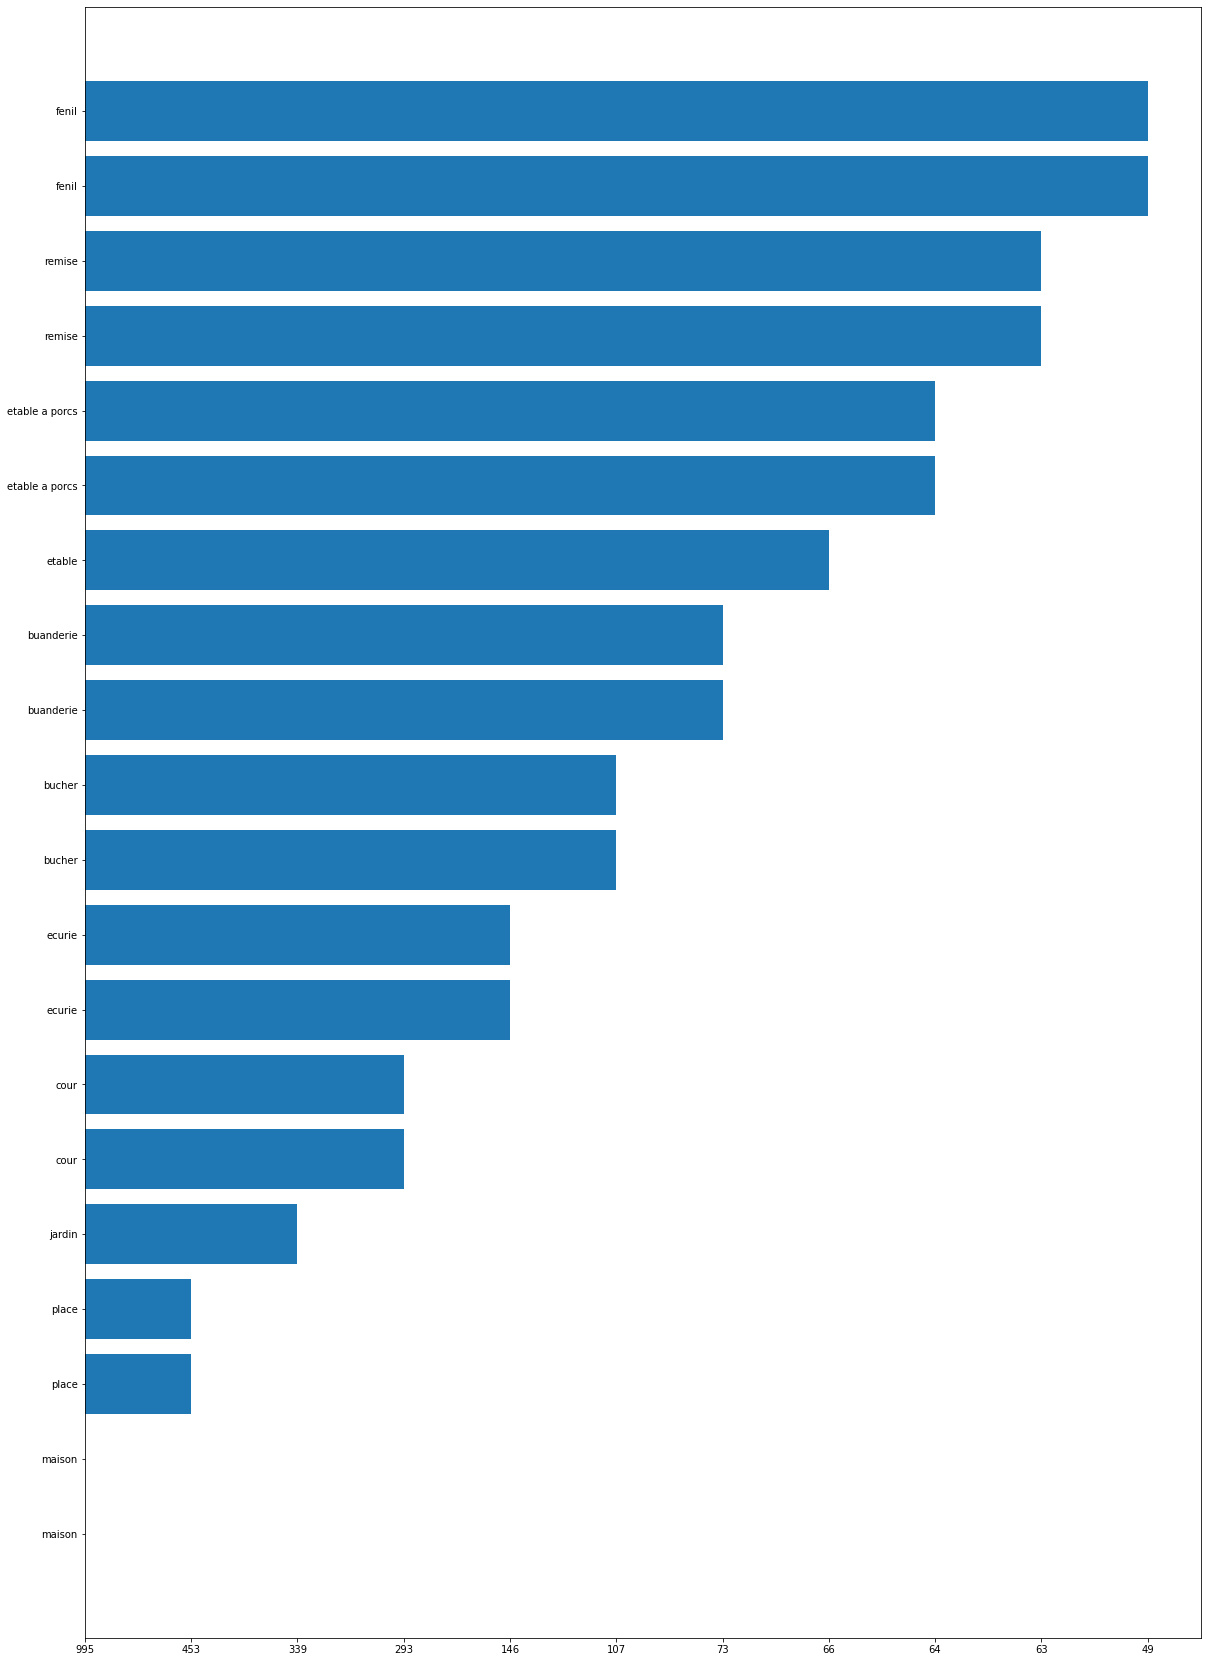

In [57]:
counts = []

for u in usages:
    _, count = find_occurences(u)
    counts.append([u, count])

def take_second(l):
    return l[1]

#print(counts)
#print(len(counts))
counts.sort(key=take_second, reverse=True)
counts = np.array(counts)
#print(counts)
#print(len(counts))

plt.figure(figsize=(20, 30))
x = np.arange(20)
plt.barh(x, counts[:20, 1], align='center', tick_label=counts[:20, 0])